In [11]:
import os

import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from chirho.dynamical.handlers import (DynamicIntervention, LogTrajectory,
                                       StaticBatchObservation,
                                       StaticIntervention)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

In [12]:
smoke_test = "CI" in os.environ
subset_starts = 420
subset_ends = 430 if smoke_test else 480
desired_frames = 500 if smoke_test else 900
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 1000
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()

In [13]:
locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=100,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

loc_subset = df["subset"]
loc_all = df["all_frames"]

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 900
resulting_shape: (13500, 4)
min_time 1
max_time 900


In [14]:
object = loc_subset
rewards = object.rewardsDF.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True)
df = object.foragersDF
start, end, N_obs = min(df["time"]), max(df["time"]), len(df["time"].unique())


display(df.head())

display(df["x"].describe())
print(rewards)

,x,y,time,forager,type
313875,13.0,51.0,420,1,locust
313876,13.0,47.0,420,2,locust
313877,3.0,63.0,420,3,locust
313878,25.0,89.0,420,4,locust
313879,19.0,48.0,420,5,locust


count    915.000000
mean      36.555191
std       27.625741
min        1.000000
25%       17.000000
50%       25.000000
75%       56.000000
max       99.000000
Name: x, dtype: float64

      x     y
0  84.0  48.0
1  15.0  48.0


,x,y,time,state
313875,13.0,51.0,420,feed_l
313876,13.0,47.0,420,feed_l
313877,3.0,63.0,420,edge_l
313878,25.0,89.0,420,search_l
313879,19.0,48.0,420,feed_l


   x  y     state  time
0  0  0    edge_l   419
1  0  0    edge_r   419
2  0  0    feed_l   419
3  0  0    feed_r   419
4  0  0  search_l   419
5  0  0  search_r   419


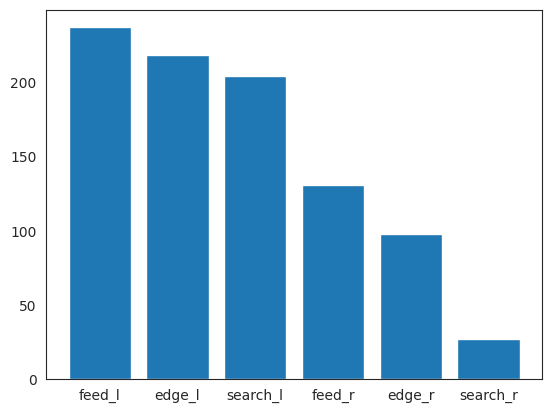

In [15]:
left_idx = rewards["x"].idxmin()
right_idx = rewards["x"].idxmax()
x_left = rewards.iloc[left_idx, 0]
y_left = rewards.iloc[left_idx, 1]

x_right = rewards.iloc[right_idx, 0]
y_right = rewards.iloc[right_idx, 1]

x_center = 50
y_center = 50


df_cat = ft.add_ring(
    df, "feed_l", x0=x_left, y0=y_left, outside_radius=10, inside_radius=0
)


df_cat = ft.add_ring(
    df_cat, "feed_r", x0=x_right, y0=y_right, outside_radius=10, inside_radius=0
)

df_cat = ft.add_ring(
    df_cat,
    "edge",
    x0=x_center,
    y0=y_center,
    outside_radius=51,
    inside_radius=47,
    divide_by_side=True,
)

df_cat = ft.add_ring(
    df_cat,
    "search",
    x0=x_center,
    y0=y_center,
    outside_radius=50,
    inside_radius=0,
    divide_by_side=True,
)


df_cat.drop(["forager", "type"], inplace=True, axis=1)

unique_states = set(df_cat["state"])


# these will be added to ensure the animation starts with
# all states represented
# ignore the initial frame in the animation
initial_fake_positions = pd.DataFrame(
    {
        "x": [0] * len(unique_states),
        "y": [0] * len(unique_states),
        "state": sorted(list(unique_states)),
        "time": [(start - 1)] * len(unique_states),
    }
)

display(df_cat.head())

print(initial_fake_positions)

plt.bar(df_cat["state"].value_counts().index, df_cat["state"].value_counts())

df_cat_vis = pd.concat([initial_fake_positions, df_cat])
object.foragersDF = df_cat_vis

In [16]:
ft.animate_foragers(
    loc_subset,
    # loc_all,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    color_by_state=True,
)

In [17]:
all_states = df_cat["state"].unique()
all_times = sorted(df_cat["time"].unique())
all_combinations = pd.DataFrame(
    [(state, time) for state in all_states for time in all_times],
    columns=["state", "time"],
)
counts = pd.merge(
    all_combinations,
    df_cat.groupby(["state", "time"]).size().reset_index(name="count"),
    how="left",
    on=["state", "time"],
)
counts["count"].fillna(0, inplace=True)

count_data = {}
for state in unique_states:
    count_data[state] = torch.tensor(counts[counts["state"] == state]["count"].values)

shapes = [tensor.shape for tensor in count_data.values()]
assert all(shape == shapes[0] for shape in shapes)


tensor_length = len(next(iter(count_data.values())))
print(f"Tensor length: {tensor_length}")
sums_per_position = [
    sum(count_data[state][k] for state in count_data) for k in range(tensor_length)
]
assert all(
    sums_per_position[0] == sum_at_k for sum_at_k in sums_per_position[1:]
), "Population count is not constant!"

Tensor length: 61


In [22]:
def moving_average(data, window_size):
    cumsum = torch.cumsum(data, dim=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1 :] / window_size


def plot_trajectories(data, all_times, window_size, title = "Counts"):
    for state, color in zip(
        ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
        ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
    ):
        if window_size == 0:
           sns.lineplot(x=all_times, y=data[state], label=f"{state}", color=color)
           plt.title(title)
        else:
            running_averages = { state: moving_average(data[state].float(), window_size)
                            for state in data}
            sns.lineplot(x=all_times[window_size - 1 :],
                        y=running_averages[state],
                        label=f"{state} (avg)",
                        color=color,
                     )
            plt.title(f"{title} (running average, window size = {window_size})")
        # plt.xlim(start, end)
        plt.xlabel("time (frames)")
        plt.ylabel("# of locust")
        plt.legend(loc="upper right")
        sns.despine()

#     plt.title("Observed counts")
#     #plt.xlim(start, end)
#     plt.xlabel("time (frames)")
#     plt.ylabel("# of locust")
#     plt.legend(loc="upper right")

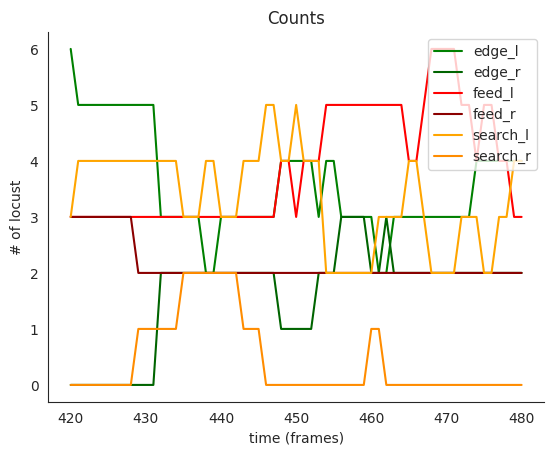

In [25]:
plot_trajectories(count_data, all_times, window_size=0)


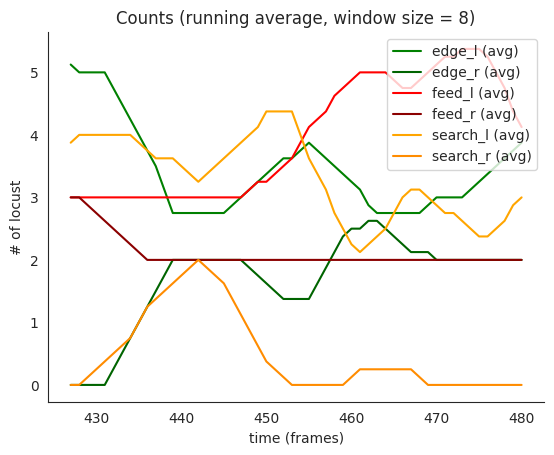

In [27]:
plot_trajectories(count_data, all_times, window_size=8)

In [28]:
locust_keys = count_data.keys()

print(count_data.keys())

# iota: pull inside
# rho: push outside
# chi: stable flow between lr within the same distance class

class LocustDynamics(pyro.nn.PyroModule):
    def __init__(self, iota_l, iota_r,  chi_l, chi_r):
        super().__init__()
        self.iota = iota
        self.rho = rho
        self.chi = chi  

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        
        dX["edge_l"] = (self.chi_l[0] * X["edge_r"] * X["edge_l"]
                        - self.iota_l[0] * X["search_l"] * X["edge_l"]
                    )
        
        dX["edge_r"] = (self.chi_r[0] * X["edge_l"] * X["edge_r"]
                        - self.iota_r[0] * X["search_r"] * X["edge_r"]
                    )
        
        dX["search_l"] = (self.chi_l[1] * X["search_r"] * X["search_l"]
                        + self.iota_l[0] * X["search_l"] * X["edge_l"]
                        - self.iota_l[1] * X["search_l"] * X["feed_l"]
                        )
        
        dX["search_r"] = (self.chi_r[1] * X["search_l"] * X["search_r"]
                        + self.iota_r[0] * X["search_r"] * X["edge_r"]
                        - self.iota_r[1] * X["search_r"] * X["feed_r"]
                        )
        
        dX["feed_l"] = (self.iota_l[1] * X["search_l"] * X["feed_l"])
        dX["feed_r"] = (self.iota_r[1] * X["search_r"] * X["feed_r"])
        
       
def locust_noisy_model(X: State[torch.Tensor]) -> None:
    event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 1 else 0

    for key in locust_keys:
        pyro.sample(
            f"{key}_obs", dist.Poisson(X[key]).to_event(event_dim)
        )


dict_keys(['edge_l', 'edge_r', 'search_l', 'search_r', 'feed_r', 'feed_l'])
